### Exercício 2.1

In [2]:
using LinearAlgebra
using PyPlot
using FFTW
# Definindo constantes
R = 1
L = 1
c = 1

# Definindo a classe circ
struct Circ
    n::Int
    matrix::Array{Complex{Float64},2}

    function Circ(n::Int)
            # Definindo constantes
        R = 1
        L = 1
        c = 1
        matrix = zeros(Complex{Float64}, n+1, n+1)
        w = 1 # Definindo w (não estava no código original, defina conforme necessário)
        
        for i in 0:n
            for k in 0:n
                if i == k
                    matrix[i+1, k+1] = (1/(im * w * c)) + (2*R + im*w*L)
                    if i >= 1
                        matrix[i+1, k] = -R
                    end
                end
            end
        end
        
        matrix[1, 1] -= R
        
        # Arrumar a última coluna depois
        for p in 0:n
            matrix[p+1, n+1] = -im*w*L
        end
        
        return new(n, matrix)
    end
end

# Criando uma instância da classe Circ
n = 5 # Exemplo de valor para n
circuit = Circ(n)
matriz = (circuit.matrix)
matriz

6×6 Matrix{ComplexF64}:
  1.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im  0.0-1.0im
 -1.0+0.0im   2.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im  0.0-1.0im
  0.0+0.0im  -1.0+0.0im   2.0+0.0im   0.0+0.0im   0.0+0.0im  0.0-1.0im
  0.0+0.0im   0.0+0.0im  -1.0+0.0im   2.0+0.0im   0.0+0.0im  0.0-1.0im
  0.0+0.0im   0.0+0.0im   0.0+0.0im  -1.0+0.0im   2.0+0.0im  0.0-1.0im
  0.0+0.0im   0.0+0.0im   0.0+0.0im   0.0+0.0im  -1.0+0.0im  0.0-1.0im

### 2.3

#### 2.2

In [5]:
# decomposição LU
function LU(A::Matrix{ComplexF64})
    A = copy(A)
    U = A
    N = size(U,1) 
    L = zeros(Complex{Float64}, N, N)
    for m in 1:N
        
        for p in  1:N
            
            if p >= m
                
                L[p,m] = U[p,m]

            end
        end
        
        # Divide by the diagonal element
        div = U[m,m]
        U[m,:] /= div
        # Now subtract from the lower rows
        
        for i in  (m+1):N
            mult = U[i,m]
            U[i,:] -= mult*U[m,:]
        end
    end
    
    return L , U
end



function solucao_LU(L::Matrix{ComplexF64}, U::Matrix{ComplexF64}, v::Vector{ComplexF64})
    N = length(v)
    y = zeros(ComplexF64, N)
    x = zeros(ComplexF64, N)
    
    # Forward substitution to solve Ly = v
    for n in 1:N
        y[n] = v[n] - sum(L[n,1:n-1] .* y[1:n-1])
        y[n] /= L[n,n]
    end
    
    # Backward substitution to solve Ux = y
    for m in N:-1:1
        x[m] = y[m] - sum(U[m,m+1:N] .* x[m+1:N])
        x[m] /= U[m,m]
    end
    
    return x
end



                
L,U = LU(matriz)
v = zeros(ComplexF64,6)
v[1] = 1
solucao_LU(L,U,v)

6-element Vector{ComplexF64}:
 0.96875 + 0.0im
 0.46875 + 0.0im
 0.21875 + 0.0im
 0.09375 + 0.0im
 0.03125 + 0.0im
     0.0 + 0.03125im

In [6]:
function fft(x)
    N = length(x)
    if N <= 1
        return x
    elseif N % 2 != 0
        throw("Input length must be a power of 2")
    end

    X_even = fft(x[1:2:end])  # Take every other element starting from the first
    X_odd = fft(x[2:2:end])   # Take every other element starting from the second

    factor = exp.(-2im * pi * (0:N-1) / N)
    X = zeros(ComplexF64, N)
    half_N = div(N, 2)
    
    X[1:half_N] .= X_even .+ factor[1:half_N] .* X_odd
    X[half_N+1:N] .= X_even .+ factor[half_N+1:N] .* X_odd

    return X
end

# Example usage
function V(t::AbstractVector)
    V_0 = 1
    T = 64
    Omega = 3
    return V_0 .* exp.(-((t .- (T / 2)).^2) / 2) .* cos.(Omega .* t)
end

N = 2048
t = range(0, stop=64, length=N)
x = V(collect(t))

# Convert the input to ComplexF64 before calling fft
x_complex = ComplexF64.(x)
c = abs.(fft(x_complex))

println("FFT of x = ")
#println(c)


N = 2048
t = range(0,64,N)
x = V(t)
c = abs.(fft(x))
#print(c)


FFT of x = 


2048-element Vector{Float64}:
 0.16069873751247649
 0.30927276258819286
 0.5669635317533508
 0.8687450184015789
 1.2205689347402713
 1.636049218625857
 2.1304900211181237
 2.719720513091765
 3.419555857839821
 4.245300388663019
 5.211168961234709
 6.329601956894323
 7.610484246204214
 ⋮
 7.610484246204205
 6.329601956894304
 5.21116896123468
 4.245300388663005
 3.419555857839807
 2.719720513091746
 2.1304900211181157
 1.636049218625833
 1.2205689347402475
 0.868745018401574
 0.5669635317533237
 0.3092727625881808

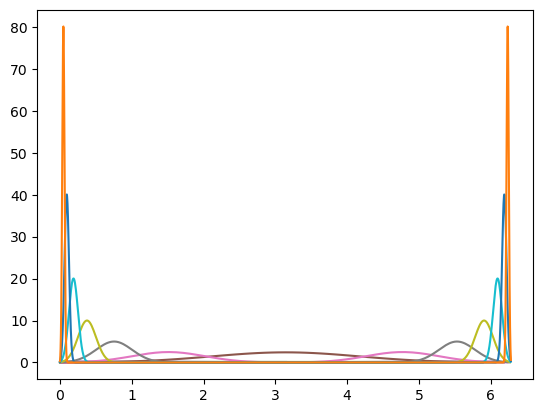

In [7]:

N = 2^15
t = range(0,64,N)
x = V(t)
ref_c = abs.(fft(x))




for N in [2,4,8,16,32,64,128,256,512,1024,2048,4096]
    t = range(0,64,N)
    x = V(t)
    c = abs.(fft(x))

    
    frequencias = (0:N-1).*(2*pi/N)
    plot(frequencias,c)
        
end


### 2.4

In [24]:
# Regra de Simpson
function simpson(f, N, a, b)
    x = range(a, b, length=N+1)
    y = f.(x)
    h = (b - a) / N
    integral = (h/3) * (y[1] + y[end] + 4*sum(y[2:2:end-1]) + 2*sum(y[3:2:end-2]))
    return integral
end

# decomposição LU
function LU(A::Matrix{ComplexF64})
    A = copy(A)
    U = A
    N = size(U,1) 
    L = zeros(Complex{Float64}, N, N)
    for m in 1:N
        
        for p in  1:N
            
            if p >= m
                
                L[p,m] = U[p,m]

            end
        end
        
        # Divide by the diagonal element
        div = U[m,m]
        U[m,:] /= div
        # Now subtract from the lower rows
        
        for i in  (m+1):N
            mult = U[i,m]
            U[i,:] -= mult*U[m,:]
        end
    end
    
    return L , U
end



function solucao_LU(L::Matrix{ComplexF64}, U::Matrix{ComplexF64}, v::Vector{ComplexF64})
    N = length(v)
    y = zeros(ComplexF64, N)
    x = zeros(ComplexF64, N)
    
    # Forward substitution to solve Ly = v
    for n in 1:N
        y[n] = v[n] - sum(L[n,1:n-1] .* y[1:n-1])
        y[n] /= L[n,n]
    end
    
    # Backward substitution to solve Ux = y
    for m in N:-1:1
        x[m] = y[m] - sum(U[m,m+1:N] .* x[m+1:N])
        x[m] /= U[m,m]
    end
    
    return x
end
# Example usage
function V(t)
    V_0 = 1
    T = 64
    Omega = 3
    return V_0 .* exp.(-((t .- (T / 2)).^2) / 2) .* cos.(Omega .* t)
end

function integranda(f,w,t)
    return f(t)*exp(t*w*1im)
end



# Função para calcular os nós de Chebyshev
function chebyshev_nodes(n)
    return cos.((2 .* (0:(n-1)) .+ 1) .* π ./ (2 .* n))
end

# Função para calcular os pesos de Chebyshev
function chebyshev_weights(n)
    return π ./ n .* ones(n)
end

# Função para calcular a integral usando quadratura de Gauss-Chebyshev
function gauss_chebyshev(f, n, a, b)
    nodes = chebyshev_nodes(n)
    weights = chebyshev_weights(n)
    # Transformação dos nós de Chebyshev para o intervalo [a, b]
    transformed_nodes = 0.5 * (b - a) * nodes .+ 0.5 * (a + b)
    # Integral aproximada
    integral = sum(weights .* f.(transformed_nodes))
    return 0.5 * (b - a) * integral
end



gauss_chebyshev (generic function with 2 methods)

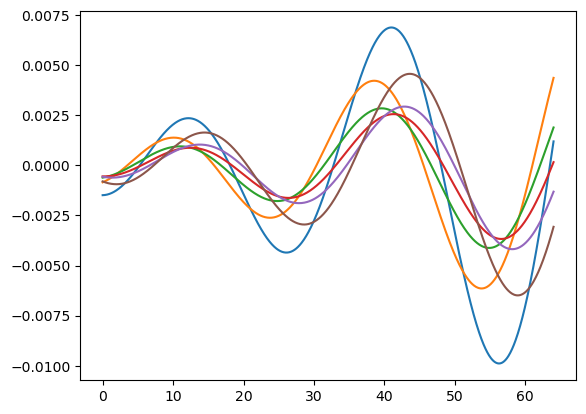

In [30]:
T = 64
N = 1000
t = range(0,T,N)
# Criando uma instância da classe Circ
n = 5 # Exemplo de valor para n
circuit = Circ(n)
matriz = (circuit.matrix)
L,U = LU(matriz)


I_w = zeros(Complex{Float64},N,n+1)
I_t = zeros(Complex{Float64},N,n+1)
w = t.*(2*pi/N)
for i in 1:N
    f(x) = integranda(V,w[i],x)
    V_w = gauss_chebyshev(f,1000,0,T)
    v = zeros(ComplexF64,n+1)
    v[1] = V_w
    I_w[i,:] = solucao_LU(L,U,v)
end
for k in 1:N
    I_t[k,:] = ifft(I_w[k,:])
end
for p in 1:n+1
    plot(t,real(I_t[:,p]))
end

### 3.1

In [12]:
# Método Runge-Kutta de quarta ordem
function rk4_4d(a, b, N, r0, f)
    h = (b - a) / N
    t = range(a, b, N)
    r = zeros(Float64,4, N)
    r[:, 1] .= r0
    
    for i in 2:N

        k1 = h * f(r[:, i-1], t[i-1])
        k2 = h * f(r[:, i-1] + 0.5 * k1, t[i-1] + 0.5 * h)
        k3 = h * f(r[:, i-1] + 0.5 * k2, t[i-1] + 0.5 * h)
        k4 = h * f(r[:, i-1] + k3, t[i-1] + h)
        
        r[:, i] = r[:, i-1] + (k1 + 2*k2 + 2*k3 + k4) / 6
    end
    
    return r
end

rk4_4d (generic function with 1 method)

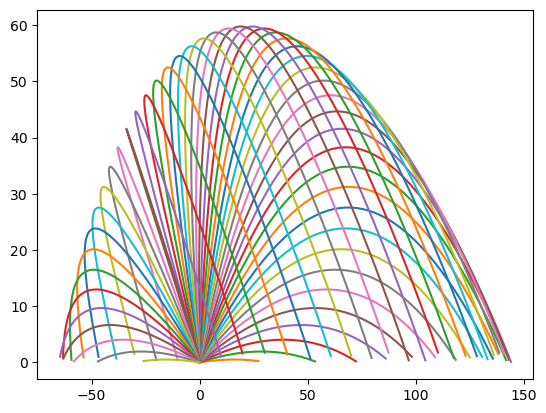

In [13]:

function Veloar(ry)
    if ry <= 0
        return 0
    else
        return 10 * (ry / 0.5) ^ (1 / 7)
    end
end

function f(r,t)
    g = 9.8
    constant = 0.4
    rx,vx,ry,vy = r
    v_ar = Veloar(ry)
    mod = abs.([vx - v_ar, vy])
    frx = vx
    fvx = -constant*(vx - v_ar)  
    fry = vy
    fvy = -g +exp((10^(-6))*ry) -constant*vy
    return [frx,fvx,fry,fvy]
end


a = 0
b_f = 100
N = 1000


t = range(0,b_f,N)

v0 = 50
theta = range(0,pi,50)

#pygui(true)

for o in theta
    r_0 = (0, v0*cos(o), 0, v0*sin(o))

    r = rk4_4d(a,b_f,N,r_0,f)
    x = r[1,:]
    y = r[3,:]


    # Parar a simulação quando o corpo atingir o solo 
    mask = y .>=0
    plot(x[mask],y[mask])
end
